In [77]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
from PIL import Image
from tqdm.notebook import tqdm
from torchvision import transforms
from catboost import Pool, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

# Load, Split, and Filter data

In [ ]:
train = pd.read_csv('/kaggle/input/cs-480-2024-spring/data/train.csv')
train['file_path'] = train['id'].apply(lambda s: f'/kaggle/input/cs-480-2024-spring/data/train_images/{s}.jpeg')

test = pd.read_csv('/kaggle/input/cs-480-2024-spring/data/test.csv')
test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/cs-480-2024-spring/data/test_images/{s}.jpeg')

#target columns
mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

#drop any train outliers
for column in mean_columns:
    upper_quantile = train[column].quantile(0.98)
    lower_quantile = train[column].quantile(0.001)
    train = train[(train[column] < upper_quantile) & (train[column] > lower_quantile)]

# Preprocessing

In [ ]:
feature_columns = test.columns.values[1:-1]
#print(f"Length: {len(feature_columns)}\n{feature_columns}")

scaler = StandardScaler()
train[feature_columns] = scaler.fit_transform(train[feature_columns].values.astype(np.float32))
test[feature_columns] = scaler.transform(test[feature_columns].values.astype(np.float32))

# Load up DinoV2 image embeddings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

def get_image_embeddings(model, preprocess_img, batch_size, df):
    embeddings = []
    for i in tqdm(range(0, len(df), batch_size)):
        img_paths = df['file_path'][i:i+batch_size]
        processed_imgs = [preprocess_img(Image.open(path)) for path in img_paths]
        img_tensor = torch.stack(processed_imgs).to(device)
        with torch.no_grad():
            img_embeddings = model(img_tensor)
        embeddings.extend(img_embeddings.cpu().numpy())
    return embeddings

# Use DinoV2 to turn images to image embeddings

In [ ]:
# Whether we want to recompute image embeddings (~2h15)
RECOMPUTE = False

In [ ]:
if RECOMPUTE:
    batch_size = 64
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg').to(CONFIG.DEVICE)
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize(224, interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    train_img_embeddings = get_image_embeddings_dino(model, preprocess, batch_size, train)
    np.save(f'train_image_embeddings', np.array(train_image_embeddings))
    test_img_embeddings = get_image_embeddings_dino(model, preprocess, batch_size, test)
    np.save(f'test_image_embeddings', np.array(test_image_embeddings))

    train['extracted_features'] = train_img_embeddings
    test['extracted_features'] = test_img_embeddings
else:
    train_img_embeddings = np.load(f'/kaggle/input/data-emebeddings/train_image_embs_dinov2_vitg14_reg.npy')
    test_img_embeddings = np.load(f'/kaggle/input/data-emebeddings/test_image_embs_dinov2_vitg14_reg.npy')

    # Delete this
    train['extracted_features'] = [list(row) for row in train_img_embeddings]
    test['extracted_features'] = [list(row) for row in test_img_embeddings]

print(type(train))

# Train on Catboost

In [ ]:
# Prepare for training
max_estimators = 1000
early_stopping_limit = 30
val_size = 0.05

X_train = train.drop(columns=mean_columns)
# Need to drop since this is non-float
X_train = X_train.drop(columns='file_path')
Y_train = train[mean_columns] 

In [75]:
models = {}
r2_scores = {}

for column in Y_train.columns:
    print("\nTraining column:", column, "...")
    X_train_split, X_test, y_train_split, y_test = train_test_split(X_train, Y_train[column], test_size=val_size, random_state=42)

    train_pool = Pool(X_train_split, y_train_split, embedding_features=['extracted_features'])
    val_pool = Pool(X_test, y_test, embedding_features=['extracted_features'])
    
    model = CatBoostRegressor(iterations=1500, learning_rate=0.03, loss_function='RMSE', eval_metric='R2', verbose=0, random_state=42)
    model.fit(train_pool, eval_set=val_pool, verbose=100)
    models[column] = model
    
    # Predict on the test set
    y_pred = model.predict(val_pool)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    r2_scores[column] = model.get_evals_result()['validation']['R2']
    print(f"R2 score for column {column}: {r2:.4f}")



Training for column: X4_mean ...
0:	learn: 0.0220317	test: 0.0242480	best: 0.0242480 (0)	total: 42.4ms	remaining: 1m 3s
100:	learn: 0.4274261	test: 0.4962637	best: 0.4962637 (100)	total: 3.5s	remaining: 48.5s
200:	learn: 0.4425056	test: 0.5091745	best: 0.5091745 (200)	total: 6.72s	remaining: 43.4s
300:	learn: 0.4517274	test: 0.5121952	best: 0.5122545 (299)	total: 9.91s	remaining: 39.5s
400:	learn: 0.4603323	test: 0.5148468	best: 0.5148468 (400)	total: 13s	remaining: 35.6s
500:	learn: 0.4694346	test: 0.5167822	best: 0.5168112 (497)	total: 16.1s	remaining: 32s
600:	learn: 0.4783904	test: 0.5174160	best: 0.5175221 (597)	total: 19.1s	remaining: 28.6s
700:	learn: 0.4868684	test: 0.5177941	best: 0.5178093 (632)	total: 22.3s	remaining: 25.4s
800:	learn: 0.4945980	test: 0.5181289	best: 0.5181289 (800)	total: 25.8s	remaining: 22.5s
900:	learn: 0.5021555	test: 0.5182179	best: 0.5185569 (865)	total: 29s	remaining: 19.3s
1000:	learn: 0.5093596	test: 0.5185597	best: 0.5187079 (976)	total: 32.2s	re

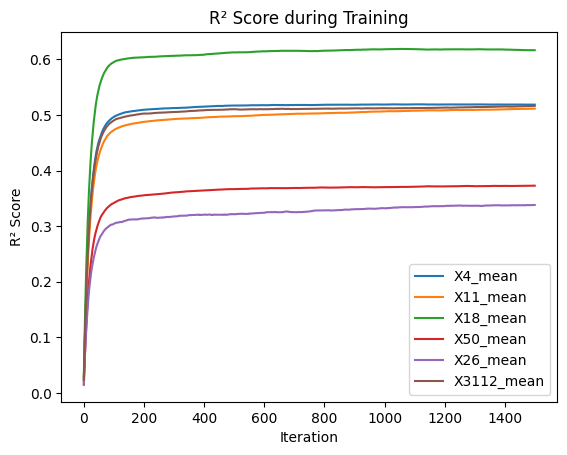

In [79]:
for column, scores in r2_scores.items():
    plt.plot(scores, label=column)

plt.xlabel('Iteration')
plt.ylabel('R² Score')
plt.title('R² Score during Training')
plt.legend()
plt.show()

# Fill in submit DF with mean of train values by default
### Provides near-0 R2 score values for any columns we don't predict for

In [ ]:
mean_values = Y_train.mean()
submission = pd.DataFrame({'id': test['id']})
submission[Y_train.columns] = mean_values

#rename from _mean
submission.columns = submission.columns.str.replace('_mean', '')
submission.head()

# Predictions for test
## R2 scores look good for all targets - so we predict on everything...

In [ ]:
test = test.drop(columns='file_path')
for i, column in enumerate(mean_columns):
    test_pool = Pool(test, embedding_features=['extracted_features'])
    column_prediction=models[column].predict(test_pool)
    submission[column.replace('_mean', '')] = column_prediction

submission.head()

# Submit!

In [ ]:
submission.to_csv('20915348_pei.csv', index=False)

In [ ]:
df = pd.read_csv('20915348_pei.csv')

submission_order = ['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112']

df = df.reindex(columns=submission_order)

df.to_csv('20915348_pei.csv', index=False)